# Synchronization of Neurons 
## Stochastic Processes and Simulations in Natural Sciences Project
### *Bergossi Cesare, Milanovic Emilija, Pezzani Giulia*

The Hodgkin-Huxley (HH) model, developed in the 1950s by Alan Hodgkin and Andrew Huxley, describes how action potentials in neurons are initiated and propagated through the cell membrane via ion channels. This project extends the HH model to simulate interactions between two coupled neurons. We used a system of differential equations to model ion channel dynamics and synaptic coupling. By adjusting parameters such as ion conductance and synaptic strength, the simulation explores their influence on neuronal behavior. Current injection into one neuron allows observation of effects on both neurons, providing valuable insights into neuronal dynamics and communication. Eventually the project includes the addition of a third neuron to further investigate how this interaction influences membrane potential.

First we install all the necessary packages.

In [2]:
# %pip install dash dash-core-components dash-html-components dash-bootstrap-components pyngrok

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import plotly.graph_objects as go

## Hodgkin-Huxley Model

This section defines the rate constants and ionic currents used in the Hodgkin-Huxley model to describe the electrical behavior of neurons. The functions are as follows:

* **alpha_m(V)**: Calculates the rate of transition of the sodium channel activation gate, from closed to open.

* **beta_m(V)**: Calculates the rate of transition of the sodium channel activation gate, from open to closed.

* **alpha_h(V)**: Calculates the rate of transition of the sodium channel inactivation gate from closed to open.

* **beta_h(V)**: Calculates the rate of transition of the sodium channel inactivation gate from open to closed.

* **alpha_n(V)**: Calculates the rate of transition of the potassium channel activation gate from closed to open.

* **beta_n(V)**: Calculates the rate of transition of the potassium channel activation gate from open to closed.

* **I_Na(V, m, h, g_Na, E_Na)**: Computes the sodium current based on membrane potential V, activation gate m, inactivation gate h, maximum sodium conductance g_Na, and sodium reversal potential E_Na.

* **I_K(V, n, g_K, E_K)**: Computes the potassium current based on membrane potential V, activation gate n, maximum potassium conductance g_K, and potassium reversal potential E_K.

* **I_L(V, g_L, E_L)**: Computes the leak current based on membrane potential V, leak conductance g_L, and leak reversal potential E_L.

* **I_inj(t, I_app)**: Defines an external current injection I_app applied to the neuron during a specific time window.




In [3]:
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

def I_Na(V, m, h, g_Na, E_Na):
    return g_Na * m**3 * h * (V - E_Na)

def I_K(V, n, g_K, E_K):
    return g_K * n**4 * (V - E_K)

def I_L(V, g_L, E_L):
    return g_L * (V - E_L)

def I_inj(t, I_app):
    return I_app * ((t > 100) & (t < 300))

## Current Injected in Both Neurons Case

### Synaptic Currents

This section describes the functions and equations used to model synaptic currents between two coupled neurons using the alpha function. We first model the case of excitatory synapse (E_syn = 0.0 mV) and then the inhibitory one (E_syn = -70.0 mV). An excitatory synapse depolarizes the postsynaptic neuron, increasing the chance of an action potential, typically with a reversal potential around 0 mV. An inhibitory synapse hyperpolarizes the postsynaptic neuron, decreasing the chance of an action potential, with a reversal potential below the resting membrane potential, often around -70 mV.

The function **I_syn(alpha, s, V, E_syn)** models the synaptic current flowing into a post-synaptic neuron. This current depends on the synaptic conductance *alpha*, the gating variable *s*, the membrane potential of the post-synaptic neuron *V*, and the synaptic reversal potential *E_syn*. The synaptic current is given by the equation:
I_syn = 𝛼⋅s⋅(V-E_syn)
which indicates that the synaptic current is proportional to the product of the synaptic conductance and the driving force (V-E_syn).

**dALLdt(t, X, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, g_syn, E_syn, tau_syn)**: Represents the system of differential equations for the dynamics of two coupled neurons. We first analyze the case in which the current is injected in both neurons. This function includes:

* Neuron 1 dynamics: describes the changes in membrane potential V1, gating variables (m1, h1, n1), and synaptic gating variable s1 for Neuron 1.

* Neuron 2 dynamics: same as for Neuron 1.

* Synaptic gating variables (s1 and s2): govern the changes in synaptic conductance based on the membrane potentials of the respective presynaptic neurons.

In [4]:
def I_syn(alpha, s, V, E_syn):
    return alpha * s * (V - E_syn)

def dALLdt(t, X, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, g_syn, E_syn, tau_syn):
    V1, m1, h1, n1, V2, m2, h2, n2, s1, s2 = X

    # Neuron 1 dynamics
    dV1dt = (I_inj(t, I_app) - I_Na(V1, m1, h1, g_Na, E_Na) - I_K(V1, n1, g_K, E_K) - I_L(V1, g_L, E_L) - I_syn(g_syn, s2, V1, E_syn)) / C_m
    dmdt1 = alpha_m(V1) * (1.0 - m1) - beta_m(V1) * m1
    dhdt1 = alpha_h(V1) * (1.0 - h1) - beta_h(V1) * h1
    dndt1 = alpha_n(V1) * (1.0 - n1) - beta_n(V1) * n1

    # Neuron 2 dynamics
    dV2dt = (I_inj(t, I_app) - I_Na(V2, m2, h2, g_Na, E_Na) - I_K(V2, n2, g_K, E_K) - I_L(V2, g_L, E_L) - I_syn(g_syn, s1, V2, E_syn)) / C_m
    dmdt2 = alpha_m(V2) * (1.0 - m2) - beta_m(V2) * m2
    dhdt2 = alpha_h(V2) * (1.0 - h2) - beta_h(V2) * h2
    dndt2 = alpha_n(V2) * (1.0 - n2) - beta_n(V2) * n2

    # Synaptic gating variables
    ds1dt = -s1 / tau_syn + np.heaviside(V1 - E_syn, 0)
    ds2dt = -s2 / tau_syn + np.heaviside(V2 - E_syn, 0)

    return dV1dt, dmdt1, dhdt1, dndt1, dV2dt, dmdt2, dhdt2, dndt2, ds1dt, ds2dt

Then we define the starting values for the simulation of the coupled neurons.

In [5]:
def initial_conditions():
    V0 = -65.0
    m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
    h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
    n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    s0 = 0.0
    return [V0, m0, h0, n0, V0, m0, h0, n0, s0, s0]

Then the **solve_ode** function solves the system of differential equations for the coupled neurons using the initial conditions and specified parameters. Specifically the `solve_ivp` function is designed to solve ODEs.

In [6]:
def solve_ode(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn):
    X0 = initial_conditions()
    t = np.linspace(0, 400, 5000)
    sol = solve_ivp(dALLdt, [0, 400], X0, args=(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn), method='LSODA', t_eval=t)
    I_injected = I_inj(t, I_app)
    return t, sol.y[0], sol.y[4], I_injected

### Excitatory Synapse

We now use the Dash app layout, which defines the structure of the web-based interface for the Hodgkin-Huxley neuron simulation. It uses Dash and Bootstrap components to create an interactive application. The layout includes, two plots for displaying each neuron's membrane potential, and sliders that allow to adjust parameters. This allows us to get a sense of the neuronal behavior.


In [7]:
app1 = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app1.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Hodgkin-Huxley Neuron Simulation"),
            dcc.Graph(id='neuron1-plot'),
            dcc.Graph(id='neuron2-plot')
        ], width=8),
        dbc.Col([
            html.H5("Parameters"),
            dbc.Label("Sodium Conductance (g_Na)"),
            dcc.Slider(id='g_Na', min=50, max=400, step=1, value=120, marks={i: str(i) for i in range(50, 401, 50)}),
            dbc.Label("Potassium Conductance (g_K)"),
            dcc.Slider(id='g_K', min=10, max=50, step=1, value=36, marks={i: str(i) for i in range(10, 51, 10)}),
            dbc.Label("Leak Conductance (g_L)"),
            dcc.Slider(id='g_L', min=0.1, max=0.5, step=0.01, value=0.3, marks={i/10: str(i/10) for i in range(1, 6)}),
            dbc.Label("Applied Current (I_app)"),
            dcc.Slider(id='I_app', min=0, max=50, step=1, value=10, marks={i: str(i) for i in range(0, 51, 10)}),
            dbc.Label("Synaptic Conductance (alpha_syn)"),
            dcc.Slider(id='alpha_syn', min=0, max=1, step=0.01, value=0.1, marks={i/10: str(i/10) for i in range(0, 11)})
        ], width=4)
    ])
])

# Update plots based on slider values
@app1.callback(
    [Output('neuron1-plot', 'figure'),
     Output('neuron2-plot', 'figure')],
    [Input('g_Na', 'value'),
     Input('g_K', 'value'),
     Input('g_L', 'value'),
     Input('I_app', 'value'),
     Input('alpha_syn', 'value')]
)
def update_figure(g_Na, g_K, g_L, I_app, alpha_syn):
    t, V1, V2, I_injected = solve_ode(1.0, g_Na, g_K, g_L, 50.0, -77.0, -54.387, I_app, alpha_syn, 0.0, 10.0)

    # Plot for Neuron 1
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t, y=V1, mode='lines', name='Neuron 1', line=dict(color='green')))
    fig1.add_trace(go.Scatter(x=t, y=I_injected, mode='lines', name='Injected Current', line=dict(dash='dash')))
    fig1.update_layout(title='Neuron 1 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV) and Injected Current (µA/cm²)')

    # Plot for Neuron 2
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=t, y=V2, mode='lines', name='Neuron 2'))
    fig2.add_trace(go.Scatter(x=t, y=I_injected, mode='lines', name='Injected Current', line=dict(dash='dash')))
    fig2.update_layout(title='Neuron 2 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV) and Injected Current (µA/cm²)')

    return fig1, fig2

if __name__ == '__main__':
    app1.run_server(debug=True, port=8057)

Of course, in the case where the current is injected into both neurons, as we could have expected, they behave similarly. The excitatory synapse means that when one neuron becomes active, it tends to make the connected neuron more active as well, leading to synchronized firing patterns. Injecting current into both neurons provides similar external stimulation, reinforcing this synchronization. The equations governing their dynamics include terms representing the synaptic influence, so when both neurons receive similar input, their behavior naturally aligns.

### Inhibitory Synapse

In [8]:
app1 = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app1.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Hodgkin-Huxley Neuron Simulation"),
            dcc.Graph(id='neuron1-plot'),
            dcc.Graph(id='neuron2-plot')
        ], width=8),
        dbc.Col([
            html.H5("Parameters"),
            dbc.Label("Sodium Conductance (g_Na)"),
            dcc.Slider(id='g_Na', min=50, max=400, step=1, value=120, marks={i: str(i) for i in range(50, 401, 50)}),
            dbc.Label("Potassium Conductance (g_K)"),
            dcc.Slider(id='g_K', min=10, max=50, step=1, value=36, marks={i: str(i) for i in range(10, 51, 10)}),
            dbc.Label("Leak Conductance (g_L)"),
            dcc.Slider(id='g_L', min=0.1, max=0.5, step=0.01, value=0.3, marks={i/10: str(i/10) for i in range(1, 6)}),
            dbc.Label("Applied Current (I_app)"),
            dcc.Slider(id='I_app', min=0, max=50, step=1, value=10, marks={i: str(i) for i in range(0, 51, 10)}),
            dbc.Label("Synaptic Conductance (alpha_syn)"),
            dcc.Slider(id='alpha_syn', min=0, max=1, step=0.01, value=0.1, marks={i/10: str(i/10) for i in range(0, 11)})
        ], width=4)
    ])
])

# Update plots based on slider values
@app1.callback(
    [Output('neuron1-plot', 'figure'),
     Output('neuron2-plot', 'figure')],
    [Input('g_Na', 'value'),
     Input('g_K', 'value'),
     Input('g_L', 'value'),
     Input('I_app', 'value'),
     Input('alpha_syn', 'value')]
)
def update_figure(g_Na, g_K, g_L, I_app, alpha_syn):
    t, V1, V2, I_injected = solve_ode(1.0, g_Na, g_K, g_L, 50.0, -77.0, -54.387, I_app, alpha_syn, -70.0, 10.0)

    # Plot for Neuron 1
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t, y=V1, mode='lines', name='Neuron 1', line=dict(color='green')))
    fig1.add_trace(go.Scatter(x=t, y=I_injected, mode='lines', name='Injected Current', line=dict(dash='dash')))
    fig1.update_layout(title='Neuron 1 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV) and Injected Current (µA/cm²)')

    # Plot for Neuron 2
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=t, y=V2, mode='lines', name='Neuron 2'))
    fig2.add_trace(go.Scatter(x=t, y=I_injected, mode='lines', name='Injected Current', line=dict(dash='dash')))
    fig2.update_layout(title='Neuron 2 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV) and Injected Current (µA/cm²)')

    return fig1, fig2

if __name__ == '__main__':
    app1.run_server(debug=True, port=8058)

As opposed to the excitatory case, the inhibitory synapse results in limited spiking, typically showing only a single spike per neuron across standard parameter values, showing the suppressive effect of inhibitory synapses on neuronal firing.

## Current Injected Only in the First Neuron Case

We now redefine the **dALLdt** function to simulate the scenario where the current is injected only into the first neuron. This modification allows us to observe how this external stimulation affects both the injected neuron and the coupled second neuron.

In [9]:
def dALLdt2(t, X, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn):
    V1, m1, h1, n1, V2, m2, h2, n2, s1, s2 = X

    # Neuron 1 dynamics
    dV1dt = (I_inj(t, I_app) - I_Na(V1, m1, h1, g_Na, E_Na) - I_K(V1, n1, g_K, E_K) - I_L(V1, g_L, E_L) - I_syn(alpha_syn, s2, V1, E_syn)) / C_m
    dmdt1 = alpha_m(V1) * (1.0 - m1) - beta_m(V1) * m1
    dhdt1 = alpha_h(V1) * (1.0 - h1) - beta_h(V1) * h1
    dndt1 = alpha_n(V1) * (1.0 - n1) - beta_n(V1) * n1

    # Neuron 2 dynamics
    dV2dt = (- I_Na(V2, m2, h2, g_Na, E_Na) - I_K(V2, n2, g_K, E_K) - I_L(V2, g_L, E_L) - I_syn(alpha_syn, s1, V2, E_syn)) / C_m
    dmdt2 = alpha_m(V2) * (1.0 - m2) - beta_m(V2) * m2
    dhdt2 = alpha_h(V2) * (1.0 - h2) - beta_h(V2) * h2
    dndt2 = alpha_n(V2) * (1.0 - n2) - beta_n(V2) * n2

    # Synaptic gating variables
    ds1dt = -s1 / tau_syn + np.heaviside(V1 - E_syn, 0)
    ds2dt = -s2 / tau_syn + np.heaviside(V2 - E_syn, 0)

    return dV1dt, dmdt1, dhdt1, dndt1, dV2dt, dmdt2, dhdt2, dndt2, ds1dt, ds2dt

In [10]:
def solve_ode2(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn):
    X0 = initial_conditions()
    t = np.linspace(0, 400, 5000)
    sol = solve_ivp(dALLdt2, [0, 400], X0, args=(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn), method='LSODA', t_eval=t)
    I_injected = I_inj(t, I_app)
    return t, sol.y[0], sol.y[4], I_injected

### Excitatory Synapse

In [11]:
app2 = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app2.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Hodgkin-Huxley Neuron Simulation"),
            dcc.Graph(id='neuron1-plot'),
            dcc.Graph(id='neuron2-plot')
        ], width=8),
        dbc.Col([
            html.H5("Parameters"),
            dbc.Label("Sodium Conductance (g_Na)"),
            dcc.Slider(id='g_Na', min=50, max=400, step=1, value=120, marks={i: str(i) for i in range(50, 401, 50)}),
            dbc.Label("Potassium Conductance (g_K)"),
            dcc.Slider(id='g_K', min=10, max=50, step=1, value=36, marks={i: str(i) for i in range(10, 51, 10)}),
            dbc.Label("Leak Conductance (g_L)"),
            dcc.Slider(id='g_L', min=0.1, max=0.5, step=0.01, value=0.3, marks={i/10: str(i/10) for i in range(1, 6)}),
            dbc.Label("Applied Current (I_app)"),
            dcc.Slider(id='I_app', min=0, max=50, step=1, value=10, marks={i: str(i) for i in range(0, 51, 10)}),
            dbc.Label("Synaptic Conductance (alpha_syn)"),
            dcc.Slider(id='alpha_syn', min=0, max=1, step=0.01, value=0.1, marks={i/10: str(i/10) for i in range(0, 11)}),
        ], width=4)
    ])
])

@app2.callback(
    [Output('neuron1-plot', 'figure'),
     Output('neuron2-plot', 'figure')],
    [Input('g_Na', 'value'),
     Input('g_K', 'value'),
     Input('g_L', 'value'),
     Input('I_app', 'value'),
     Input('alpha_syn', 'value')]
)
def update_figure(g_Na, g_K, g_L, I_app, alpha_syn):
    t, V1, V2, I_injected = solve_ode2(1.0, g_Na, g_K, g_L, 50.0, -77.0, -54.387, I_app, alpha_syn, 0.0, 10.0)

    # Plot for Neuron 1
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t, y=V1, mode='lines', name='Neuron 1', line=dict(color='green')))
    fig1.add_trace(go.Scatter(x=t, y=V2, mode='lines', name='Neuron 2'))
    fig1.add_trace(go.Scatter(x=t, y=I_injected, mode='lines', name='Injected Current', line=dict(dash='dash')))
    fig1.update_layout(title='Neuron 1 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV) and Injected Current (µA/cm²)')

    # Plot for Neuron 2
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=t, y=V2, mode='lines', name='Neuron 2', line=dict(color='red')))
    fig2.update_layout(title='Neuron 2 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV)')

    return fig1, fig2

if __name__ == '__main__':
    app2.run_server(debug=True, port=8058)


Based on the plots showing the membrane potentials of two neurons, where Neuron 1 is injected with current and Neuron 2 is synaptically connected to Neuron 1, several observations can be made. Neuron 1 exhibits a series of action potentials during the current injection period (from 100 ms to 300 ms), indicating an active response to the external stimulus. Its membrane potential rapidly depolarizes and repolarizes, displaying typical action potential behavior, and returns to its resting state after the injection period. Neuron 2, though not directly injected with current, shows synchronized action potentials due to its excitatory synaptic connection to Neuron 1.

This indicates effective synaptic transmission, as the synaptic input from Neuron 1 brings Neuron 2 to the threshold for firing action potentials. The variable influence is also notable: increased sodium conductance (*g_Na*) induces higher action potential peaks and firing frequency, while decreased *g_Na* reduces these effects. Higher potassium conductance (*g_K*) quickens repolarization, affecting the timing of Neuron 2's spikes, whereas lower *g_K* increases action potential duration. Higher leak conductance (*g_L*) stabilizes the membrane potential, making threshold-reaching harder, thus reducing spikes in Neuron 2, while lower *g_L* makes the neuron more excitable, potentially increasing spike frequency. Lastly, higher synaptic conductance (*alpha_syn*) strengthens synaptic coupling and enhances synchronization, while lower alpha_syn weakens it, leading to fewer spikes in Neuron 2 despite Neuron 1's activity.

### Inhibitory Synapse

In [12]:
app2 = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app2.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Hodgkin-Huxley Neuron Simulation"),
            dcc.Graph(id='neuron1-plot'),
            dcc.Graph(id='neuron2-plot')
        ], width=8),
        dbc.Col([
            html.H5("Parameters"),
            dbc.Label("Sodium Conductance (g_Na)"),
            dcc.Slider(id='g_Na', min=50, max=400, step=1, value=120, marks={i: str(i) for i in range(50, 401, 50)}),
            dbc.Label("Potassium Conductance (g_K)"),
            dcc.Slider(id='g_K', min=10, max=50, step=1, value=36, marks={i: str(i) for i in range(10, 51, 10)}),
            dbc.Label("Leak Conductance (g_L)"),
            dcc.Slider(id='g_L', min=0.1, max=0.5, step=0.01, value=0.3, marks={i/10: str(i/10) for i in range(1, 6)}),
            dbc.Label("Applied Current (I_app)"),
            dcc.Slider(id='I_app', min=0, max=50, step=1, value=10, marks={i: str(i) for i in range(0, 51, 10)}),
            dbc.Label("Synaptic Conductance (alpha_syn)"),
            dcc.Slider(id='alpha_syn', min=0, max=1, step=0.01, value=0.1, marks={i/10: str(i/10) for i in range(0, 11)}),
        ], width=4)
    ])
])

@app2.callback(
    [Output('neuron1-plot', 'figure'),
     Output('neuron2-plot', 'figure')],
    [Input('g_Na', 'value'),
     Input('g_K', 'value'),
     Input('g_L', 'value'),
     Input('I_app', 'value'),
     Input('alpha_syn', 'value')]
)
def update_figure(g_Na, g_K, g_L, I_app, alpha_syn):
    t, V1, V2, I_injected = solve_ode2(1.0, g_Na, g_K, g_L, 50.0, -77.0, -54.387, I_app, alpha_syn, -70.0, 10.0)

    # Plot for Neuron 1
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t, y=V1, mode='lines', name='Neuron 1', line=dict(color='green')))
    fig1.add_trace(go.Scatter(x=t, y=V2, mode='lines', name='Neuron 2'))
    fig1.add_trace(go.Scatter(x=t, y=I_injected, mode='lines', name='Injected Current', line=dict(dash='dash')))
    fig1.update_layout(title='Neuron 1 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV) and Injected Current (µA/cm²)')

    # Plot for Neuron 2
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=t, y=V2, mode='lines', name='Neuron 2', line=dict(color='red')))
    fig2.update_layout(title='Neuron 2 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV)')

    return fig1, fig2

if __name__ == '__main__':
    app2.run_server(debug=True, port=8059)

The first neuron receives the injected current, which causes it to spike, as expected. The second neuron, connected via the inhibitory synapse, initially shows a slight hyperpolarization due to the inhibitory influence of the first neuron. This inhibition suppresses any significant spiking activity in the second neuron. For high enough injected current, a small rebound spike appears in the second neuron right after cessation of the injected current in the first neuron. This post-stimulation spike is caused by a rebound effect, where the sudden removal of input causes the second neuron to briefly depolarize as it recovers from inhibition. However, it does not generate substantial activity due to the overall inhibitory effect and the system returning to equilibrium.

When the injected current is increased above a certain threshold, the first neuron exhibits regular spiking behavior, instead of just one spike. The second neuron again shows initial suppression of its membrane potential, and as seen previously, when the injected current stops, it exhibits a little spike in membrane potential. 

Now we further analyse the parameters. Note that in our simulations, we observed that with standard parameter values, inhibitory synapses tend to limit each neuron to a single spike when current is injected into both neurons (for standard level of injected current). This reduction in neuronal firing contrasts with the more continuous spiking seen with excitatory synapses. Due to this limited spiking behavior under standard conditions, a deeper analysis of changing individual parameters for the inhibitory synapse case does not yield significant insights. Therefore, we will not further explore parameter variations for this inhibitory scenario.

## Effect of Synaptic Strenght on Neuron Synchronization

Now we wanted to investigate the relationship between synaptic strength and neuronal synchronization. Specifically, the resulting plot helps to understand if stronger synaptic connections lead to more synchronized neuronal activity or if there is an optimal synaptic strength that maximizes synchronization. 

To do so we first compute the cross correlation between the neurons' membrane potential. This allows to quantify the degree to which two signals are similar over time. By computing the cross-correlation, we can determine how synchronized the firing patterns of the two neurons are.

Then we plot it against synaptic conductance *alpha_syn* to assess how changes in synaptic strength impact the degree of synchronization between neurons.

In [13]:
C_m = 1.0
g_Na = 120
g_K = 36
g_L = 0.3
E_Na = 50.0
E_K = -77.0
E_L = -54.387
I_app = 10
tau_syn = 10.0
alpha_syn = 0.1

In [14]:
def solve_ode3(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn):
    X0 = initial_conditions()
    t = np.linspace(0, 400, 5000)
    sol = solve_ivp(dALLdt2, [0, 400], X0, args=(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn), method='LSODA', t_eval=t)

    g_Na1 = g_Na * sol.y[1]**3 * sol.y[2]
    g_K1 = g_K * sol.y[3]**4
    g_L1 = g_L

    g_Na2 = g_Na * sol.y[5]**3 * sol.y[6]
    g_K2 = g_K * sol.y[7]**4
    g_L2 = g_L

    I_injected = I_inj(t, I_app)
    return t, sol.y[0], sol.y[4], I_injected, g_Na1, g_K1, g_L1, g_Na2, g_K2, g_L2

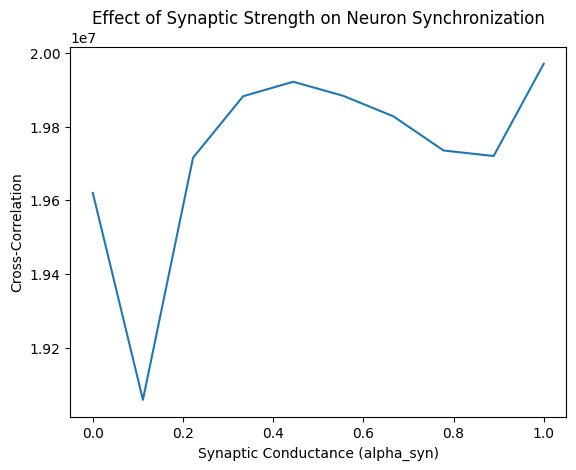

In [15]:
def compute_cross_correlation(V1, V2):
    return np.max(np.correlate(V1, V2, mode='full'))

alpha_syn_values = np.linspace(0, 1, 10)
cross_correlation_values = []

for alpha_syn in alpha_syn_values:
    t, V1, V2, I_injected, g_Na1, g_K1, g_L1, g_Na2, g_K2, g_L2 = solve_ode3(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, 0, tau_syn)
    cross_corr = compute_cross_correlation(V1, V2)
    cross_correlation_values.append(cross_corr)

# Plot the cross-correlation against synaptic strength
plt.plot(alpha_syn_values, cross_correlation_values)
plt.xlabel('Synaptic Conductance (alpha_syn)')
plt.ylabel('Cross-Correlation')
plt.title('Effect of Synaptic Strength on Neuron Synchronization')
plt.show()

The graph shows that as synaptic conductance increases from 0 to 1, the level of synchronization between the neurons fluctuates. Initially, there is a dip in synchronization at lower synaptic conductance values, followed by an increase that peaks around a mid-range value, and then a slight decline before rising again at the highest conductance levels. This indicates that neuron synchronization is not linear with respect to synaptic strength and suggests the presence of an optimal range of synaptic conductance for maximum synchronization. 

## Impact of Sodium and Potassium Conductance on Neuronal Firing Frequency

To investigate the influence of sodium and potassium conductances on the firing frequency of neurons, we define a function to calculate the frequency of action potentials based on the membrane potential. The `calculate_frequency` function identifies the number of spikes by detecting when the membrane potential crosses zero from below, and computes the frequency. We then vary g_Na and g_K over a range of values, solving the Hodgkin-Huxley model for each conductance value to obtain the membrane potential over time. By calculating the firing frequency for each case, we generate a plot showing how the conductances affect neuronal firing frequency.

In [16]:
C_m = 1.0
g_Na = 120
g_K = 36
g_L = 0.3
E_Na = 50.0
E_K = -77.0
E_L = -54.387
I_app = 10
tau_syn = 10.0
alpha_syn = 0.1

In [17]:
def calculate_frequency(V, t):
    spikes = np.where((V[:-1] < 0) & (V[1:] >= 0))[0]
    return len(spikes) / (t[-1] - t[0]) * 1000  # Convert to Hz

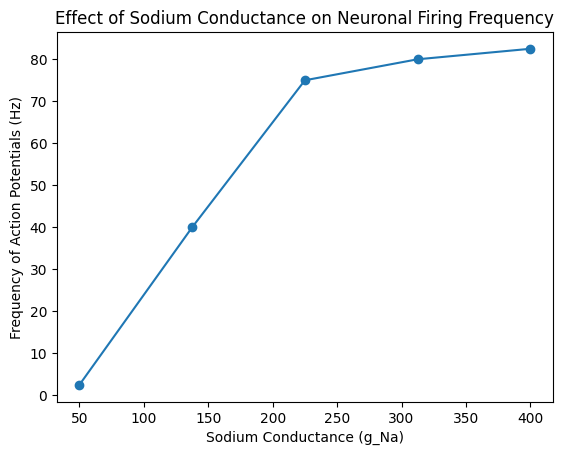

In [19]:
g_Na_values = np.linspace(50, 400, 5)
g_K = 36
frequencies = []

for g_Na in g_Na_values:
    t, V1, V2, I_injected = solve_ode2(1.0, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, 0.0, tau_syn)
    freq = calculate_frequency(V1, t)
    frequencies.append(freq)

plt.figure()
plt.plot(g_Na_values, frequencies, marker='o')
plt.xlabel('Sodium Conductance (g_Na)')
plt.ylabel('Frequency of Action Potentials (Hz)')
plt.title('Effect of Sodium Conductance on Neuronal Firing Frequency')
plt.show()

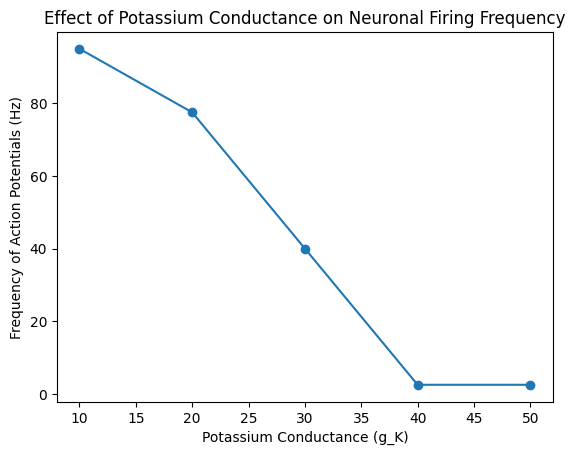

In [20]:
g_Na = 120
g_K_values = np.linspace(10, 50, 5)
frequencies = []

for g_K in g_K_values:
    t, V1, V2, I_injected = solve_ode2(1.0, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, 0.0, tau_syn)
    freq = calculate_frequency(V1, t)
    frequencies.append(freq)

plt.figure()
plt.plot(g_K_values, frequencies, marker='o')
plt.xlabel('Potassium Conductance (g_K)')
plt.ylabel('Frequency of Action Potentials (Hz)')
plt.title('Effect of Potassium Conductance on Neuronal Firing Frequency')
plt.show()

The plots demonstrate that increasing sodium conductance (*g_Na*) results in higher frequencies of action potentials (positive correlation). This indicates that higher *g_Na* facilitates spiking activity. Conversely, increasing potassium conductance (*g_K*) leads to lower frequencies of action potentials (negative correlation). This suggests that higher *g_K* enhances the neuron's repolarization, making it more difficult to sustain frequent firing. Thus, *g_Na* and *g_K* play crucial roles in regulating neuronal excitability and firing patterns.

## Influence of Leak Conductance on Neuronal Dynamics

Now we explore how varying the leak conductance (*g_L*) affects the membrane potentials of two synaptically coupled Hodgkin-Huxley neurons. We simulate the neuron dynamics for three different values of leak conductance: g_L = 0.1, g_L = 0.3, and g_L = 0.5. By plotting the membrane potentials over time for each value of g_L, we observe how changes in passive ionic flow influence neuronal behavior.

In [21]:
C_m = 1.0
g_Na = 120
g_K = 36
g_L = 0.3
E_Na = 50.0
E_K = -77.0
E_L = -54.387
I_app = 10
E_syn = 0.0
tau_syn = 10.0
alpha_syn = 0.1

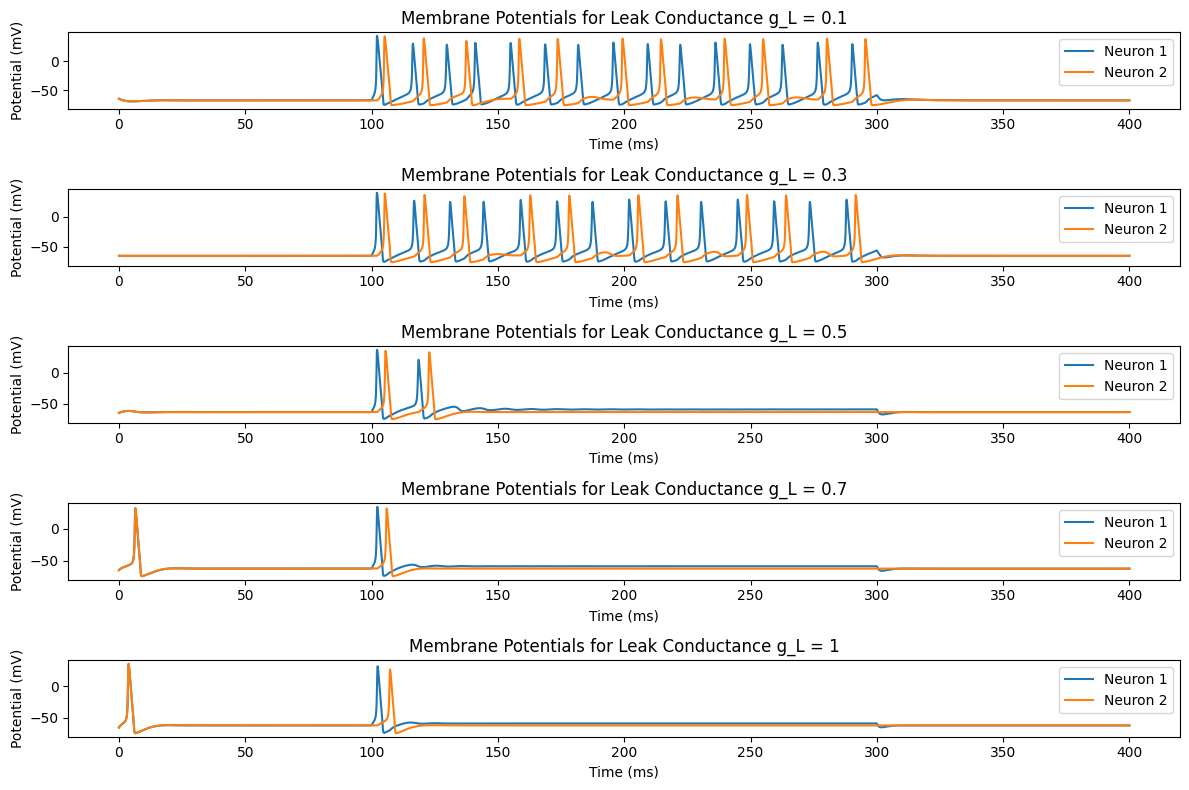

In [22]:
g_L_values = [0.1, 0.3, 0.5, 0.7, 1]
membrane_potentials = []

for g_L in g_L_values:
    t, V1, V2, I_injected = solve_ode2(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn)
    membrane_potentials.append((t, V1, V2))

# Plot
plt.figure(figsize=(12, 8))

for i, g_L in enumerate(g_L_values):
    t, V1, V2 = membrane_potentials[i]
    plt.subplot(len(g_L_values), 1, i+1)
    plt.plot(t, V1, label='Neuron 1')
    plt.plot(t, V2, label='Neuron 2')
    plt.title(f'Membrane Potentials for Leak Conductance g_L = {g_L}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Potential (mV)')
    plt.legend()

plt.tight_layout()
plt.show()


The plots illustrate how varying leak conductance affects the membrane potentials. As *g_L* increases from 0.1 to 1.0, the neurons' excitability decreases significantly. At low g_L, neurons exhibit frequent spiking, indicating high excitability. With intermediate g_L values (0.3 and 0.5), spiking frequency and amplitude decrease. At high g_L (0.7 and 1.0), neurons show limited or no spiking, demonstrating reduced excitability. This shows how higher leak conductance stabilizes neuronal activity.


The initial spike in Neuron 2 at higher leak conductance values (g_L = 0.7 and g_L = 1.0) can be attributed to the initial conditions of the model, the applied current (I_app), and potential transient dynamics at the start of the simulation. Indeed these factors might place the neuron close enough to the threshold to cause an action potential, and the applied current can momentarily drive the membrane potential above it. Additionally, transient dynamics can result in early spikes as the neurons adjust to the new parameters before the high leak conductance stabilizes their membrane potentials. 

## Three Neurons Case

Now we extend the Hodgkin-Huxley model to simulate three synaptically coupled neurons. The first neuron receives an external current injection, while the second neuron receives synaptic input from both the first and third neurons. The third neuron, in turn, receives synaptic input from the second neuron. This setup allows us to explore more complex interactions and how the activity of one neuron can influence the others through synaptic connections. The equations and initial conditions have been adjusted to account for the additional neuron and its dynamics. 

In [23]:
def ds_dt(s, V, V_pre, tau_syn, E_syn):
    return -s / tau_syn + np.heaviside(V_pre - E_syn, 0)

def stdp_update(t_pre, t_post, w, A_plus=0.01, A_minus=0.012, tau_plus=20.0, tau_minus=20.0):
    delta_t = t_post - t_pre
    if delta_t > 0:
        delta_w = A_plus * np.exp(-delta_t / tau_plus)
    else:
        delta_w = -A_minus * np.exp(delta_t / tau_minus)
    w += delta_w
    return w

In [24]:
def dALLdt3(t, X, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn, w1, w2):
    V1, m1, h1, n1, V2, m2, h2, n2, V3, m3, h3, n3, s1, s2, s3 = X

    dV1dt = (I_inj(t, I_app) - I_Na(V1, m1, h1, g_Na, E_Na) - I_K(V1, n1, g_K, E_K) - I_L(V1, g_L, E_L) - I_syn(w1, s2, V1, E_syn)) / C_m
    dmdt1 = alpha_m(V1) * (1.0 - m1) - beta_m(V1) * m1
    dhdt1 = alpha_h(V1) * (1.0 - h1) - beta_h(V1) * h1
    dndt1 = alpha_n(V1) * (1.0 - n1) - beta_n(V1) * n1

    dV2dt = (- I_Na(V2, m2, h2, g_Na, E_Na) - I_K(V2, n2, g_K, E_K) - I_L(V2, g_L, E_L) - I_syn(w1, s1, V2, E_syn) - I_syn(w2, s3, V2, E_syn)) / C_m
    dmdt2 = alpha_m(V2) * (1.0 - m2) - beta_m(V2) * m2
    dhdt2 = alpha_h(V2) * (1.0 - h2) - beta_h(V2) * h2
    dndt2 = alpha_n(V2) * (1.0 - n2) - beta_n(V2) * n2

    dV3dt = (- I_Na(V3, m3, h3, g_Na, E_Na) - I_K(V3, n3, g_K, E_K) - I_L(V3, g_L, E_L) - I_syn(w2, s2, V3, E_syn)) / C_m
    dmdt3 = alpha_m(V3) * (1.0 - m3) - beta_m(V3) * m3
    dhdt3 = alpha_h(V3) * (1.0 - h3) - beta_h(V3) * h3
    dndt3 = alpha_n(V3) * (1.0 - n3) - beta_n(V3) * n3

    ds1dt = ds_dt(s1, V1, V1, tau_syn, E_syn)
    ds2dt = ds_dt(s2, V2, V2, tau_syn, E_syn)
    ds3dt = ds_dt(s3, V3, V3, tau_syn, E_syn)

    return dV1dt, dmdt1, dhdt1, dndt1, dV2dt, dmdt2, dhdt2, dndt2, dV3dt, dmdt3, dhdt3, dndt3, ds1dt, ds2dt, ds3dt

def initial_conditions2():
    V0 = -65.0
    m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
    h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
    n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    s0 = 0.0
    return [V0, m0, h0, n0, V0, m0, h0, n0, V0, m0, h0, n0, s0, s0, s0]

def solve_ode4(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn, w1, w2):
    X0 = initial_conditions2()
    t = np.linspace(0, 400, 5000)
    sol = solve_ivp(dALLdt3, [0, 400], X0, args=(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, I_app, alpha_syn, E_syn, tau_syn, w1, w2), method='LSODA', t_eval=t)
    return t, sol.y

### Excitatory Synapses

In [25]:
app3 = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app3.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Hodgkin-Huxley Neuron Simulation"),
            dcc.Graph(id='neuron1-plot'),
            dcc.Graph(id='neuron2-plot'),
            dcc.Graph(id='neuron3-plot')
        ], width=8),
        dbc.Col([
            html.H5("Parameters"),
            dbc.Label("Sodium Conductance (g_Na)"),
            dcc.Slider(id='g_Na', min=50, max=400, step=1, value=120, marks={i: str(i) for i in range(50, 401, 50)}),
            dbc.Label("Potassium Conductance (g_K)"),
            dcc.Slider(id='g_K', min=10, max=50, step=1, value=36, marks={i: str(i) for i in range(10, 51, 10)}),
            dbc.Label("Leak Conductance (g_L)"),
            dcc.Slider(id='g_L', min=0.1, max=0.5, step=0.01, value=0.3, marks={i/10: str(i/10) for i in range(1, 6)}),
            dbc.Label("Applied Current (I_app)"),
            dcc.Slider(id='I_app', min=0, max=50, step=1, value=10, marks={i: str(i) for i in range(0, 51, 10)}),
            dbc.Label("Synaptic Conductance (alpha_syn)"),
            dcc.Slider(id='alpha_syn', min=0, max=1, step=0.01, value=0.1, marks={i/10: str(i/10) for i in range(0, 11)}),
        ], width=4)
    ])
])

# Update plots based on slider values
@app3.callback(
    [Output('neuron1-plot', 'figure'),
     Output('neuron2-plot', 'figure'),
     Output('neuron3-plot', 'figure')],
    [Input('g_Na', 'value'),
     Input('g_K', 'value'),
     Input('g_L', 'value'),
     Input('I_app', 'value'),
     Input('alpha_syn', 'value')]
)
def update_figure(g_Na, g_K, g_L, I_app, alpha_syn):
    t, sol = solve_ode4(1.0, g_Na, g_K, g_L, 50.0, -77.0, -54.387, I_app, alpha_syn, 0.0, 10.0, 0.1, 0.1)

    # Plot for Neuron 1
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t, y=sol[0], mode='lines', name='Neuron 1'))
    fig1.add_trace(go.Scatter(x=t, y=sol[4], mode='lines', name='Neuron 2'))
    fig1.add_trace(go.Scatter(x=t, y=sol[8], mode='lines', name='Neuron 3'))
    fig1.add_trace(go.Scatter(x=t, y=I_inj(t, I_app), mode='lines', name='Injected Current', line=dict(dash='dash')))
    fig1.update_layout(title='Neuron 1 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV) and Injected Current (µA/cm²)')

    # Plot for Neuron 2
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=t, y=sol[4], mode='lines', name='Neuron 2', line=dict(color='red')))
    fig2.update_layout(title='Neuron 2 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV)')

    # Plot for Neuron 3
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=t, y=sol[8], mode='lines', name='Neuron 3', line=dict(color='green')))
    fig3.update_layout(title='Neuron 3 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV)')

    return fig1, fig2, fig3

if __name__ == '__main__':
    app3.run_server(debug=True, port=8060)

The plot shows that the membrane potential of Neuron 1 repeatedly spikes due to the applied current, indicating regular action potential firing. Neuron 2 and Neuron 3, connected sequentially, also exhibit spikes but with different patterns. Neuron 2's firing pattern closely follows Neuron 1 due to the direct synaptic connection. Peaks of Neuron 3 appear to be slightly delayed and higher than those of Neuron 2. This is due to the cumulative effect of synaptic inputs as the action potentials propagate through the neurons. Each neuron can amplify the incoming signal slightly, resulting in higher peaks in subsequent neurons. 

### Inhibitory Synapse

In [26]:
app3 = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app3.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Hodgkin-Huxley Neuron Simulation"),
            dcc.Graph(id='neuron1-plot'),
            dcc.Graph(id='neuron2-plot'),
            dcc.Graph(id='neuron3-plot')
        ], width=8),
        dbc.Col([
            html.H5("Parameters"),
            dbc.Label("Sodium Conductance (g_Na)"),
            dcc.Slider(id='g_Na', min=50, max=400, step=1, value=120, marks={i: str(i) for i in range(50, 401, 50)}),
            dbc.Label("Potassium Conductance (g_K)"),
            dcc.Slider(id='g_K', min=10, max=50, step=1, value=36, marks={i: str(i) for i in range(10, 51, 10)}),
            dbc.Label("Leak Conductance (g_L)"),
            dcc.Slider(id='g_L', min=0.1, max=0.5, step=0.01, value=0.3, marks={i/10: str(i/10) for i in range(1, 6)}),
            dbc.Label("Applied Current (I_app)"),
            dcc.Slider(id='I_app', min=0, max=50, step=1, value=10, marks={i: str(i) for i in range(0, 51, 10)}),
            dbc.Label("Synaptic Conductance (alpha_syn)"),
            dcc.Slider(id='alpha_syn', min=0, max=1, step=0.01, value=0.1, marks={i/10: str(i/10) for i in range(0, 11)}),
        ], width=4)
    ])
])

# Update plots based on slider values
@app3.callback(
    [Output('neuron1-plot', 'figure'),
     Output('neuron2-plot', 'figure'),
     Output('neuron3-plot', 'figure')],
    [Input('g_Na', 'value'),
     Input('g_K', 'value'),
     Input('g_L', 'value'),
     Input('I_app', 'value'),
     Input('alpha_syn', 'value')]
)
def update_figure(g_Na, g_K, g_L, I_app, alpha_syn):
    t, sol = solve_ode4(1.0, g_Na, g_K, g_L, 50.0, -77.0, -54.387, I_app, alpha_syn, -70.0, 10.0, 0.1, 0.1)

    # Plot for Neuron 1
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t, y=sol[0], mode='lines', name='Neuron 1'))
    fig1.add_trace(go.Scatter(x=t, y=sol[4], mode='lines', name='Neuron 2'))
    fig1.add_trace(go.Scatter(x=t, y=sol[8], mode='lines', name='Neuron 3'))
    fig1.add_trace(go.Scatter(x=t, y=I_inj(t, I_app), mode='lines', name='Injected Current', line=dict(dash='dash')))
    fig1.update_layout(title='Neuron 1 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV) and Injected Current (µA/cm²)')

    # Plot for Neuron 2
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=t, y=sol[4], mode='lines', name='Neuron 2', line=dict(color='red')))
    fig2.update_layout(title='Neuron 2 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV)')

    # Plot for Neuron 3
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=t, y=sol[8], mode='lines', name='Neuron 3', line=dict(color='green')))
    fig3.update_layout(title='Neuron 3 Membrane Potential Over Time',
                      xaxis_title='Time (ms)',
                      yaxis_title='Membrane Potential (mV)')

    return fig1, fig2, fig3

if __name__ == '__main__':
    app3.run_server(debug=True, port=8061)


In the case of three neurons with an inhibitory synapse, the first neuron receives the injected current and exhibits a spike in membrane potential. This spike inhibits the second neuron, which shows a slight hyperpolarization instead of a spike. The third neuron, influenced by the second neuron, also exhibits a minor hyperpolarization but even less than the second neuron. The inhibitory synapses ensure that the spikes in the first neuron prevent spikes in subsequent neurons, leading to a dampening effect observed in the membrane potentials of the second and third neurons.